In [262]:
#import necessary libraries
import numpy as np
import math
import scipy.spatial.distance as sc
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
#initialization of the snake, takes a pair of x and y coordinates
#to determine where the center of the snake will lie, along with a radius
#for the size of the snake, and number of contour points
def create_snake(center_x, center_y, radius, num_pts):
    samples = np.linspace(0, 2*math.pi, num_pts)
    snake = np.zeros((num_pts,2))
    snake[:,0] = np.round(radius * np.cos(samples) + center_x)
    snake[:,1] = np.round(radius * np.sin(samples) + center_y)
    return snake

In [3]:
#calculate the average distance between each contour point in a snake
#based on the Euclidean distance
def average_distance(snake):
    d = 0
    for i in range(len(snake)-1):
        d += sc.euclidean(snake[i], snake[i+1])
    d /= len(snake)
    return d

In [4]:
#calculate the internal energy terms for a given point
#requires 3 points, corresponding to pi-1, pi and pi+1
#along with the average distance between each contour point
def energy_internal(p1, p2, p3, avg_dist):
    current_dist = sc.euclidean(p1, p2)
    diff = avg_dist - current_dist
    econt = np.square(diff)
    term1 = p1[0] - (2*p2[0]) + p3[0]
    term2 = p1[1] - (2*p2[1]) + p3[1]
    ecurve = np.sqrt(np.square(term1) + np.square(term2))
    return econt, ecurve

In [5]:
#find the xy coordinates of 8 neighbors surrounding a given point
def get_neighbors(p):
    neighbors = []
    x = int(p[0])
    y = int(p[1])
    for i in range(x-1,x+2):
        for j in range(y-1,y+2):
            neighbors.append([i,j])
    return neighbors

In [241]:
#greedy DFS algorithm
#takes as input an initialized snake, an image containing the object to segment
#3 parameters for tuning each energy term and the max number of iterations to run the algorithm
#energy term is minimized and points are shifted towards the location of this minimum energy at each iteration
#points are handled in a loop, which means that the first and last points of the snake
#use each other for the calculation of their respective energy terms
#algortihm terminates once max iteration number has been reached, or when no points have moved
def deformable_contour_segmentation(snake, img, alpha, beta, gamma, max_iterations):
    new_snake = snake.copy()
    e_external = -nd.gaussian_gradient_magnitude(img, sigma=5)
    current_iteration = 0
    finished = False
    while current_iteration < max_iterations and finished == False:
        no_change = []
        avg_dist = average_distance(new_snake)
        for i in range(len(snake)):
            energy = 100000000
            ind = 0
            neighbors = get_neighbors(new_snake[i])
            j = i-1
            k = i+1
            if i == 0:
                j = len(new_snake) - 1
            elif i == len(new_snake) - 1:
                k = 0
            for n in neighbors:
                e_int = energy_internal(new_snake[j], n, new_snake[k], avg_dist)
                if len(img.shape) > 2:
                    e_total = (alpha*e_int[0]) + (beta*e_int[1]) + (gamma*min(e_external[n[0]][n[1]]))
                else:
                    e_total = (alpha*e_int[0]) + (beta*e_int[1]) + (gamma*e_external[n[0]][n[1]])
                if e_total < energy:
                    energy = e_total
                    ind = n
            if new_snake[i][0] == ind[0] and new_snake[i][1] == ind[1]:
                no_change.append(1)
            else:
                no_change.append(0)
            new_snake[i] = ind
        if 0 not in no_change:
            finished = True
        current_iteration += 1
    return new_snake

In [70]:
#initialize snake for the implied_contour image
#show the implied_contour image
initial_snake = create_snake(380, 430, 350, 50)

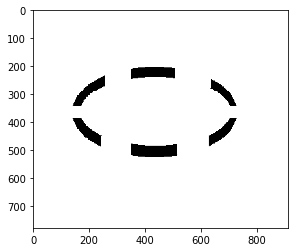

In [8]:
im = plt.imread("C:/Users/jack_/Downloads/implied_contour.png")
plt.imshow(im)

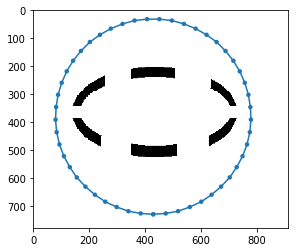

In [238]:
#plot contour points around a given image
#used to visualize the segmentation once the DFS algorithm has been applied
def plot_snake(snake, img, point_thickness):
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(img, cmap='gray')
    xx = []
    yy = []
    for s in snake:
        circ = Circle((s[1],s[0]),point_thickness)
        ax.add_patch(circ)
        xx.append(s[1])
        yy.append(s[0])
    plt.plot(xx,yy)
    plt.show()
plot_snake(initial_snake, im, 8)

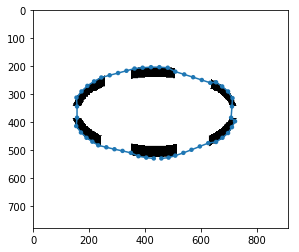

In [242]:
#apply DFS using the initialized snake and the image
#plot the correctly segmented object
dfs = deformable_contour_segmentation(initial_snake, im, 0.1, 0.5, 1000, 200)
plot_snake(dfs, im, 8)

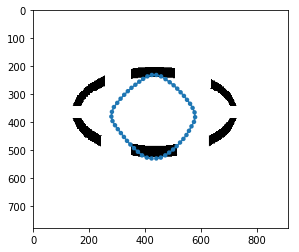

In [243]:
#plot the incorrectly segmented object
dfs2 = deformable_contour_segmentation(initial_snake, im, 0.1, 0.5, 10, 200)
plot_snake(dfs2, im, 8)

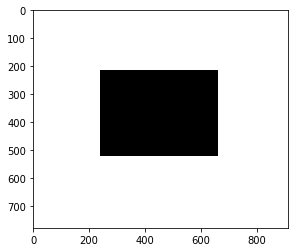

In [79]:
#show the next test image
im2 = plt.imread("C:/Users/jack_/Downloads/rectangle.png")
plt.imshow(im2)

In [248]:
#initialize three snakes with 10, 30 and 500 points respectively
initial_snake10 = create_snake(370, 450, 350, 10)
initial_snake30= create_snake(370, 450, 350, 30)
initial_snake500 = create_snake(370, 450, 350, 500)

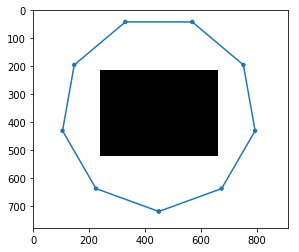

In [244]:
plot_snake(initial_snake10, im2, 8)

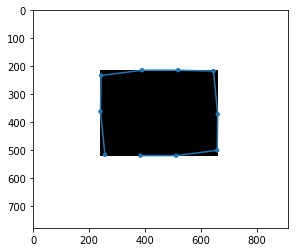

In [261]:
#apply DFS using the snake with 10 and the rectangle image
dfs_rect = deformable_contour_segmentation(initial_snake10, im2, 0.1, 0.5, 1000, 400)
plot_snake(dfs_rect, im2, 8)

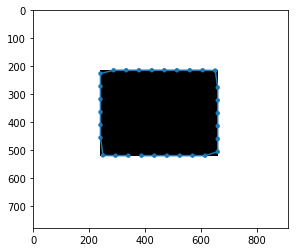

In [246]:
#apply DFS using snake with 30 points
dfs_rect = deformable_contour_segmentation(initial_snake30, im2, 0.1, 0.005, 1000, 400)
plot_snake(dfs_rect, im2, 8)

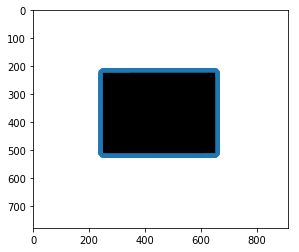

In [249]:
#apply DFS using snake with 500 points
dfs_rect = deformable_contour_segmentation(initial_snake500, im2, 0.1, 0.5, 1000, 400)
plot_snake(dfs_rect, im2, 8)

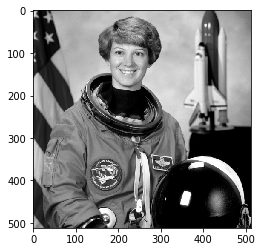

In [143]:
#show the astronaut image
im3 = plt.imread("C:/Users/jack_/Downloads/astronaut.png")
plt.imshow(im3, cmap='gray')

In [257]:
#initialize a snake with 50 points to segment the desired object
initial_snake50 = create_snake(100, 220, 95, 50)

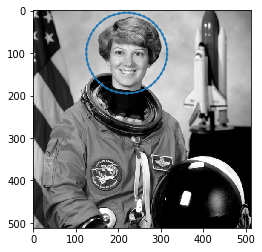

In [258]:
#show the initial snake around the desired object, the astronaut's head
plot_snake(initial_snake50, im3, 3)

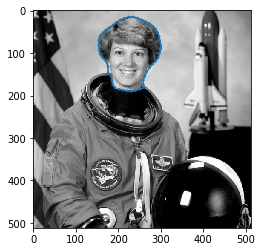

In [259]:
#apply DFS using the appropriate parameters
dfs_astr = deformable_contour_segmentation(initial_snake50, im3, 0.5, 0.5, 1000, 500)
plot_snake(dfs_astr, im3, 3)

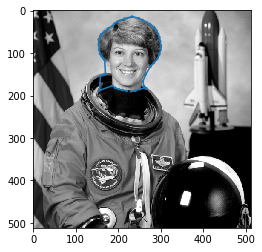

In [252]:
#apply DFS using a small alpha parameter to showcase the snake being attracted to other edges
dfs_astr = deformable_contour_segmentation(initial_snake50, im3, 0.05, 0.5, 1000, 500)
plot_snake(dfs_astr, im3, 3)